In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':"1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW"})   

downloaded.GetContentFile('ratings_Electronics.csv') 

In [4]:
df = pd.read_csv("ratings_Electronics.csv", 
                  names=["UserID", "ProductID", "Rating", "Timestamp"])
df.head(10)

,UserID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


In [5]:
df.drop(columns="Timestamp",inplace=True)

In [6]:
df.shape

(7824482, 3)

Checking the data

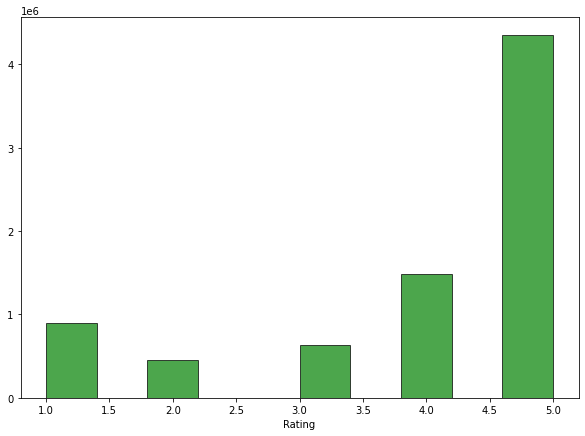

In [7]:
plt.figure(figsize= (10,7))
plt.subplot(1,1,1)
plt.hist(df['Rating'], color='green', edgecolor = 'black', alpha = 0.7)
plt.xlabel('Rating')
plt.show()

#### As we can see there are not values in between and the majority of the rating is 5 with 4 about 1/3 rd of 5 rated recording.

In [8]:
users = df['UserID'].unique()
print('The number of unique users')
len(users)

The number of unique users


4201696

In [9]:
products = df['ProductID'].unique()
print('The number of unique products')
len(products)

The number of unique products


476002

Grouping by Users

In [16]:
user_df=df.groupby(['UserID']).agg({'Rating':'count'}).reset_index()
new_df = user_df.rename(columns={'Rating':'count'})
new_df

,UserID,count
0,A00000262KYZUE4J55XGL,1
1,A000063614T1OE0BUSKUT,2
2,A00009182QVLSWIGHLS1B,1
3,A00009661LC9LQPGKJ24G,1
4,A00010809P09NUU6ZP6H,1
...,...,...
4201691,AZZZOVIBXHGDR,3
4201692,AZZZRS1YZ8HVP,2
4201693,AZZZSIK7NFFVP,1
4201694,AZZZWXXUPZ1F3,1


Only using data of users which have more than 50 reveiws

In [49]:
group_df=pd.merge(df, new_df, how='left',left_on='UserID', right_on='UserID')
new_df1=group_df[group_df['count']>50]

## Popularity based Recommendation System

In [50]:
avg=new_df1.groupby(['ProductID']).agg({'Rating':'mean'}).reset_index()

count=new_df1.groupby(['ProductID']).agg({'Rating':'count'}).reset_index()
count= count.rename(columns={'Rating':'count'})
group=pd.merge(avg, count, how='left',left_on='ProductID', right_on='ProductID')
sort_group=group.sort_values(['count','Rating'],ascending =(False,False))
sort_group.head(10)                                                        

,ProductID,Rating,count
38146,B0088CJT4U,4.215686,204
24262,B003ES5ZUU,4.858757,177
10820,B000N99BBC,4.773006,163
37407,B007WTAJTO,4.692308,156
37765,B00829TIEK,4.431507,146
38471,B008DWCRQW,4.088889,135
37761,B00829THK0,4.409091,132
21486,B002R5AM7C,4.118110,127
28121,B004CLYEDC,4.666667,117
21708,B002SZEOLG,4.287037,108


In [52]:
sort_group.count()

ProductID    47155
Rating       47155
count        47155
dtype: int64

#### Popularity Based Recommender

In [57]:
def recommend(user_id):     
    user_recommendations = sort_group 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations [:5]

In [63]:
print("Here is the top 5 recommendation for the userId: %s\n" %('AKM1MP6P0OYPR'))
print(recommend('AKM1MP6P0OYPR'))    
print("\n") 

Here is the top 5 recommendation for the userId: AKM1MP6P0OYPR

              userID   ProductID    Rating  count
38146  AKM1MP6P0OYPR  B0088CJT4U  4.215686    204
24262  AKM1MP6P0OYPR  B003ES5ZUU  4.858757    177
10820  AKM1MP6P0OYPR  B000N99BBC  4.773006    163
37407  AKM1MP6P0OYPR  B007WTAJTO  4.692308    156
37765  AKM1MP6P0OYPR  B00829TIEK  4.431507    146




Popularity based recommendation system will be the same for all users since it is not personalised.

In [14]:
!pip install scikit-surprise

In [39]:

from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from collections import defaultdict

In [18]:
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(new_df1[['UserID', 'ProductID', 'Rating']], reader)


Splitting Data

In [19]:
train_data, test_data = train_test_split(data, test_size = 0.30, random_state=0)


In [20]:
train_data

Collaborative Recommendation System 

In [26]:
algo= KNNWithMeans(k=40, sim_options={'name': 'pearson_baseline', 'user_based': True})

Fitting the model

In [27]:
algo.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Predicting the model with test data

In [28]:
test_pred = algo.test(test_data)

Evaluating the model

In [25]:
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0584


1.058442884927924

We can see the model performs with Root Mean Squared Error of 1.0 which is ok to work with.

Method to get top 5 predictions for the user

In [41]:
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [43]:
top_n = get_top_n(test_pred, n=5)

Getting the top 5 recommendation of products based on User 

In [67]:
for uid, user_ratings in top_n.items():
    print(uid,[iid for (iid, _) in user_ratings])

A1LAGS8H4A2DR7 ['B00A3YDPWS', 'B00AJHDZSI', 'B0015CRAZA', 'B00884WH74', 'B008S94KQK']
A3ER6ARJ23CIN8 ['B003UE52ME', 'B001D7REIK', 'B000067SOH', 'B001EAQTRI', 'B0034XRDUA']
A1CYTBE7LLUQ8F ['B000U5TUWE', 'B001FW9QGQ', 'B00275EVAQ', 'B001D8S9E2', 'B003WV5DJC']
A2MOD50IHEDH3G ['B003A7CDY6', 'B0019EHU8G', 'B006EKIQYM', 'B00DV51DTS', 'B00742BLO6']
A2WF58BAWLVI95 ['B00FF8CZJ6', 'B000799LU4', 'B000GX9KFM', 'B00F6AVFK8', 'B0002VFXGI']
A2WLNSZ9U0T1S3 ['B0014KOB6Y', 'B000U6AHZW', 'B001SEQN3U', 'B001UE8LU6', 'B001FN3ZRQ']
A2O6HZ2B9YSRXR ['B003VAM32E', 'B004Q0T0LU', 'B001TH7GUK', 'B002G1YPH0', 'B001TH7T2U']
A34C9AFFZOI45T ['B001UNM414', 'B001P3PSR6', 'B000V1PB0M', 'B000SEQGT2', 'B002MP5JX4']
A3U41ZL33SS92P ['B001CZ9ZEE', 'B000XP8DJC', 'B00F0DD0I6', 'B003FG7IG0', 'B003ES5ZUU']
A3S5WYWYKSAI9C ['B004H8FNC6', 'B0007YZTUU', 'B000EVNWVO', 'B00ISKS402', 'B00CKAOJA0']
AFXTKAO0CB354 ['B000M3GODW', 'B00005T3FO', 'B002IJ95ZM', 'B000067SPR', 'B003CYKCG8']
A38RMU1Y5TDP9 ['B000PFGX6U', 'B00519RW1U', 'B009M27MB2'

Cross validation test to check how the model will perform in production

In [35]:
cross_validate(algo,data,measures=['RMSE','MAE'],cv=5,verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0556  1.0653  1.0518  1.0546  1.0500  1.0555  0.0053  
MAE (testset)     0.7709  0.7787  0.7731  0.7712  0.7716  0.7731  0.0029  
Fit time          0.87    0.81    0.84    0.83    0.83    0.83    0.02    
Test time         0.58    0.57    0.72    0.54    0.

{'fit_time': (0.8683419227600098,
  0.8145294189453125,
  0.837529182434082,
  0.8256680965423584,
  0.8268022537231445),
 'test_mae': array([0.77089958, 0.77872761, 0.7730629 , 0.77124637, 0.7716002 ]),
 'test_rmse': array([1.05560031, 1.06529103, 1.05184831, 1.05459648, 1.04995706]),
 'test_time': (0.5787627696990967,
  0.5651381015777588,
  0.7172088623046875,
  0.5443878173828125,
  0.5510683059692383)}

From k-folds we find the model performs with about 1 RMSE error and 0.7 MAE which is fine for this model

Summary:

We can see we have eliminated those users which have not  given minimum 50 reveiews. Each product was grouped and their mean rating was found out. and the number of reveiew receiveed for the item. Then the popularity and collaborative user-user recommendation system was applied to recommed the best product recommendation for each user.


Insights:
 
 The data is skewed towards 5.0 star rating so most of the users have given 5.0 than any other rating.
 This might have impacted the recommendation system as there is a chance that the user might have given 5 star rating wihtout actaully liking it.
